In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
import numpy as np
import pylamp.utils.functions as fn
import matplotlib.pyplot as plt
from pylamp.loss.losses import CrossEntropyLoss
from pylamp.neural.sequential import Sequential
from pylamp.neural.layers import Linear, Conv1D, MaxPool1D, Flatten
from pylamp.optim.optimizer import Optim
from pylamp.neural.activations import ReLU,Softmax,TanH
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import cv2
from sklearn.metrics import accuracy_score
from pylamp.optim.optimizer import SGD
from pylamp.utils.usps import load_usps
from pylamp.utils.plotter import Display
import pandas as pd

In [30]:
X_train = pd.read_csv("./data/ArabicChars/csvTrainImages.csv").values
X_test = pd.read_csv("./data/ArabicChars/csvTestImages.csv").values

In [31]:
X_train.shape, X_test.shape

((13439, 1024), (3359, 1024))

In [32]:
X_train = X_train.reshape(len(X_train),32, 32)
X_test = X_test.reshape(len(X_test),32, 32)

In [33]:
X_train.shape, X_test.shape

((13439, 32, 32), (3359, 32, 32))

In [34]:
# Initialize an empty array to store resized images
resized_array = np.empty((len(X_train), 16, 16))

# Resize each image in the array from 32x32 to 16x16
for i in range(len(X_train)):
    resized_array[i] = cv2.resize(np.uint8(X_train[i]), (16, 16))

X_train = resized_array
resized_array = np.empty((len(X_test), 16, 16))

# Resize each image in the array from 32x32 to 16x16
for i in range(len(X_test)):
    resized_array[i] = cv2.resize(np.uint8(X_test[i]), (16, 16))

X_test = resized_array

In [35]:
X_train.shape, X_test.shape

((13439, 16, 16), (3359, 16, 16))

In [36]:
X_train = X_train.reshape((len(X_train),-1)) 
X_test = X_test.reshape((len(X_test),-1)) 

In [37]:
X_train.shape, X_test.shape

((13439, 256), (3359, 256))

In [38]:
# features scaling
# scaler = MinMaxScaler() 


scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

In [39]:
y_train = pd.read_csv("./data/ArabicChars/csvTrainLabel.csv")
y_test = pd.read_csv("./data/ArabicChars/csvTestLabel.csv")

In [40]:
y_test = y_test["1"].astype(str).str.zfill(2)
y_test = pd.get_dummies(y_test, prefix='').astype(int).values

y_train = y_train["1"].astype(str).str.zfill(2)
y_train = pd.get_dummies(y_train, prefix='').astype(int).values

In [41]:
arabic_alphabet = {
    1: 'ا',  # Alif
    2: 'ب',  # Ba
    3: 'ت',  # Ta
    4: 'ث',  # Tha
    5: 'ج',  # Jeem
    6: 'ح',  # Haa
    7: 'خ',  # Khaa
    8: 'د',  # Dal
    9: 'ذ',  # Dhal
    10: 'ر',  # Ra
    11: 'ز',  # Zay
    12: 'س',  # Seen
    13: 'ش',  # Sheen
    14: 'ص',  # Saad
    15: 'ض',  # Daad
    16: 'ط',  # Taa
    17: 'ظ',  # Zaa
    18: 'ع',  # Ain
    19: 'غ',  # Ghain
    20: 'ف',  # Fa
    21: 'ق',  # Qaf
    22: 'ك',  # Kaf
    23: 'ل',  # Lam
    24: 'م',  # Meem
    25: 'ن',  # Noon
    26: 'ه',  # Ha
    27: 'و',  # Waw
    28: 'ي'   # Ya
}

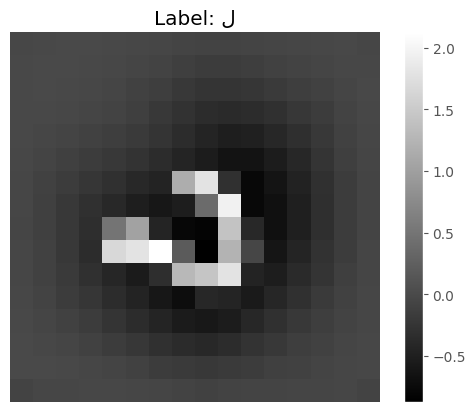

In [42]:
index = np.random.randint(len(X_train))
image = X_train[index]
label = arabic_alphabet[np.argmax(y_train[index])+1]

Display().plot_arabic(image, label)

# model linear

In [58]:


input_size = X_train.shape[1]
output_size = y_train.shape[1]

# Create a sequential model
model = Sequential()

# Add modules to the sequential model
model.add_module(Linear(input_size=input_size, output_size=128)) 
model.add_module(TanH())
model.add_module(Linear(input_size=128, output_size=64)) 
model.add_module(TanH())
model.add_module(Linear(input_size=64, output_size=output_size)) 

loss_func = CrossEntropyLoss()
optimizer = Optim(model,loss_func,1e-2)
batch_size = 128
epochs = 100
losses = SGD(optimizer,X_train, y_train, batch_size,epochs,verbose=True)

Epoch 1/100, Average Loss: 2.044742816912815


Epoch 11/100, Average Loss: 0.3205365426804381
Epoch 21/100, Average Loss: 0.06263425272636346
Epoch 31/100, Average Loss: 0.010085705251176667
Epoch 41/100, Average Loss: 0.005534544926842407
Epoch 51/100, Average Loss: 0.003922476523939697
Epoch 61/100, Average Loss: 0.003028537026662436
Epoch 71/100, Average Loss: 0.0024567744837300713
Epoch 81/100, Average Loss: 0.0020685742813106164
Epoch 91/100, Average Loss: 0.0017738564985009498
Training finished.


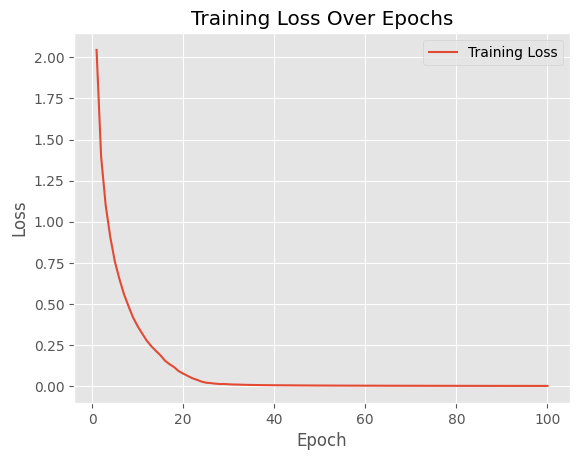

In [59]:
Display().plot_loss(losses)

In [60]:
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.forward(X_test),axis=1)

In [61]:
np.unique(y_pred)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27], dtype=int64)

In [62]:
print("Accuracy:", accuracy_score(y_true, y_pred))

Accuracy: 0.6606132777612385


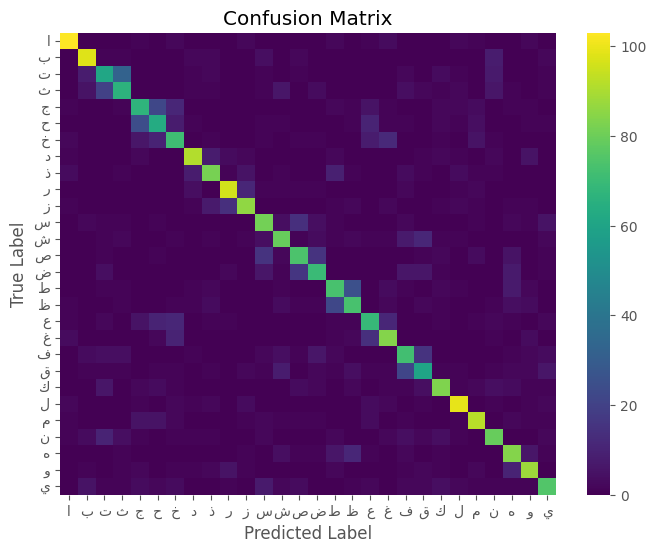

In [63]:
Display().confusion_matrix(y_true, y_pred, arabic_alphabet.values())

# Model Convolution

net = Sequential(
    Conv1D(3, 1, 32, 1),
    ReLU(),
    MaxPool1D(2, 2),
    Conv1D(3, 32, 32),
    ReLU(),
    MaxPool1D(2, 2),
    Flatten(),
    Linear(1984, 10),
)

In [49]:
input_size = 256
output_size = 28  # Number of classes for classification

model = Sequential()

# Add modules to the sequential model
model.add_module(Conv1D(in_channels=1, out_channels=32, kernel_size=3, strides=1))
model.add_module(ReLU())
model.add_module(MaxPool1D(kernel_size=2, strides=2))
model.add_module(Conv1D(in_channels=32, out_channels=32, kernel_size=3, strides=1))
model.add_module(ReLU())
model.add_module(MaxPool1D(kernel_size=2, strides=2))
model.add_module(Flatten())
model.add_module(Linear(1984 , output_size))

loss_func = CrossEntropyLoss()
optimizer = Optim(model,loss_func,1e-2)
batch_size = 64
epochs = 10
losses = SGD(optimizer,X_train, y_train, batch_size,epochs,add_channel_x=True,verbose=True)

Epoch 1/10, Average Loss: 2.362333372693175
Epoch 2/10, Average Loss: 1.6283650314431253
Epoch 3/10, Average Loss: 1.352100165951159
Epoch 4/10, Average Loss: 1.1804824662749598
Epoch 5/10, Average Loss: 1.0722840294949625
Epoch 6/10, Average Loss: 0.9834978199246606
Epoch 7/10, Average Loss: 0.9149510208629744
Epoch 8/10, Average Loss: 0.8596295454419096
Epoch 9/10, Average Loss: 0.8092094888428196
Epoch 10/10, Average Loss: 0.7590228229500136
Training finished.


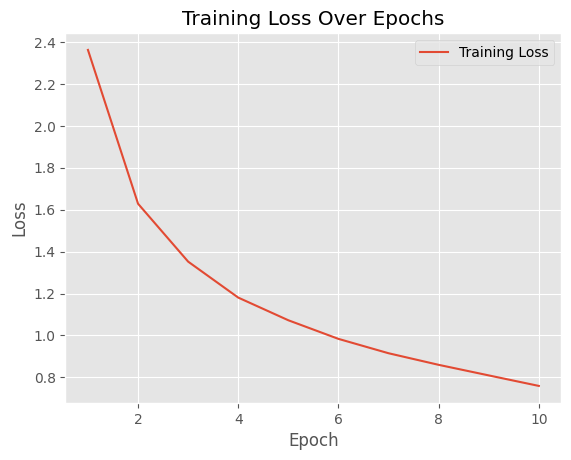

In [54]:
Display().plot_loss(losses)

In [68]:
y_true = np.argmax(y_train, axis=1)
y_pred = np.argmax(model.forward(np.expand_dims(X_test, axis=-1)),axis=1)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 256 is different from 1)

In [56]:
print("Accuracy:", accuracy_score(y_true, y_pred))

Accuracy: 0.6629949389699316


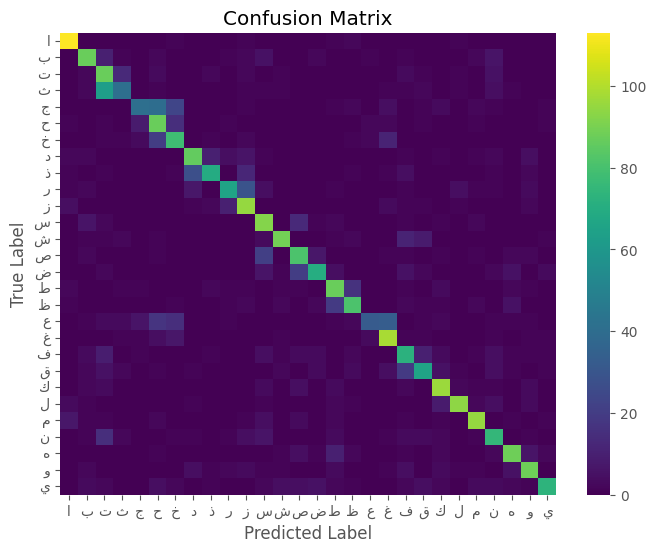

In [57]:
Display().confusion_matrix(y_true, y_pred, arabic_alphabet.values())